Notes: 这一章 与学习目的关系不大，将采用阅读的方式完成.

https://www.learnpytorch.io/04_pytorch_custom_datasets/

“What is a custom dataset?" 

*PyTorch includes many existing functions to load in various custom datasets in the [`TorchVision`](https://pytorch.org/vision/stable/index.html), [`TorchText`](https://pytorch.org/text/stable/index.html), [`TorchAudio`](https://pytorch.org/audio/stable/index.html) and [`TorchRec`](https://pytorch.org/torchrec/) domain libraries.*

But sometimes these existing functions may not be enough.

In that case, we can always subclass `torch.utils.data.Dataset` and customize it to our liking.  A custom dataset is specific dataset of own our own problem. 

## What we're going to cover

We're going to be applying the PyTorch Workflow we covered in [notebook 01](https://www.learnpytorch.io/01_pytorch_workflow/) and [notebook 02](https://www.learnpytorch.io/02_pytorch_classification/) to a computer vision problem.

But instead of using an in-built PyTorch dataset, we're going to be using our own dataset of pizza, steak and sushi images.

The goal will be to load these images and then build a model to train and predict on them.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-food-vision-layout.png" alt="building a pipeline to load in food images and then building a pytorch model to classify those food images" width=800 />

*What we're going to build. We'll use `torchvision.datasets` as well as our own custom `Dataset` class to load in images of food and then we'll build a PyTorch computer vision model to hopefully be able to classify them.*

Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **0. Importing PyTorch and setting up device-agnostic code** | Let's get PyTorch loaded and then follow best practice to setup our code to be device-agnostic.  |
| **1. Get data** | We're going to be using our own **custom dataset** of pizza, steak and sushi images. |
| **2. Become one with the data (data preparation)** | At the beginning of any new machine learning problem, it's paramount to understand the data you're working with. Here we'll take some steps to figure out what data we have. |
| **3. Transforming data** |Often, the data you get won't be 100% ready to use with a machine learning model, here we'll look at some steps we can take to *transform* our images so they're ready to be used with a model. | 
| **4. Loading data with `ImageFolder` (option 1)** | PyTorch has many in-built data loading functions for common types of data. `ImageFolder` is helpful if our images are in standard image classification format. |
| **5. Loading image data with a custom `Dataset`** | What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of `torch.utils.data.Dataset`. |
| **6. Other forms of transforms (data augmentation)** | Data augmentation is a common technique for expanding the diversity of your training data. Here we'll explore some of `torchvision`'s in-built data augmentation functions. |
| **7. Model 0: TinyVGG without data augmentation** | By this stage, we'll have our data ready, let's build a model capable of fitting it. We'll also create some training and testing functions for training and evaluating our model. |
| **8. Exploring loss curves** | Loss curves are a great way to see how your model is training/improving over time. They're also a good way to see if your model is **underfitting** or **overfitting**. |
| **9. Model 1: TinyVGG with data augmentation** | By now, we've tried a model *without*, how about we try one *with* data augmentation? |
| **10. Compare model results** | Let's compare our different models' loss curves and see which performed better and discuss some options for improving performance. |
| **11. Making a prediction on a custom image** | Our model is trained to on a dataset of pizza, steak and sushi images. In this section we'll cover how to use our trained model to predict on an image *outside* of our existing dataset. |

## 0. Importing PyTorch and setting up device-agnostic code

In [2]:
import torch
from torch import nn

torch.__version__

'2.10.0+cpu'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## 1. Getting Data

The data we are going to use is a subset of the [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).
Food101 is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).

Instead of 101 food classes though, we're going to start with 3: pizza, steak and sushi.

And instead of 1,000 images per class, we're going to start with a random 10% (start small, increase when necessary).

If you'd like to see where the data came from you see the following resources:
* Original [Food101 dataset and paper website](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).
* [`torchvision.datasets.Food101`](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html) - the version of the data I downloaded for this notebook.
* [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) - a notebook I used to format the Food101 dataset to use for this notebook.
* [`data/pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip) - the zip archive of pizza, steak and sushi images from Food101, created with the notebook linked above.

Let's write some code to download the formatted data from GitHub.

In [4]:
import requests
import zipfile
from pathlib import Path

# Setting up the data path
data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download and unzip the data
if image_path.is_dir():
    print(f"{image_path} directory already exists, skipping download.")
else:
    print(f"{image_path} directory does not exist, downloading data...")
    image_path.mkdir(parents=True, exist_ok=True)
    #Download pizza,steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)
    # Unzip the data    
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory does not exist, downloading data...
Unzipping pizza, steak, sushi data...


## 2. Become one with the data


Data preparation is paramount. Before building a model, become one with the data. Ask: What am I trying to do here? 

Before starting a project or building any kind of model, it's important to know what data you're working with.

In our case, we have images of pizza, steak and sushi in standard image classification format.

Image classification format contains separate classes of images in separate directories titled with a particular class name.

For example, all images of pizza are contained in the pizza/ directory.

This format is popular across many different image classification benchmarks, including ImageNet (of the most popular computer vision benchmark datasets).

You can see an example of the storage format below, the images numbers are arbitrary.


The goal will be to **take this data storage structure and turn it into a dataset usable with PyTorch**.

> **Note:** The structure of the data you work with will vary depending on the problem you're working on. But the premise still remains: become one with the data, then find a way to best turn it into a dataset compatible with PyTorch.

We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present.

To do so, we'll use Python's in-built [`os.walk()`](https://docs.python.org/3/library/os.html#os.walk). 

```
pizza_steak_sushi/ <- overall dataset folder
    train/ <- training images
        pizza/ <- class name as folder name
            image01.jpeg
            image02.jpeg
            ...
        steak/
            image24.jpeg
            image25.jpeg
            ...
        sushi/
            image37.jpeg
            ...
    test/ <- testing images
        pizza/
            image101.jpeg
            image102.jpeg
            ...
        steak/
            image154.jpeg
            image155.jpeg
            ...
        sushi/
            image167.jpeg
            ...
```

In [5]:
import os

def walk_through_dir(dir_path):
    """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
        
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


It looks like we've got about 75 images per training class and 25 images per testing class.

That should be enough to get started.

Remember, these images are subsets of the original Food101 dataset.

You can see how they were created in the [data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).

In [6]:
# Setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize the data

Okay, we've seen how our directory structure is formatted.

Now in the spirit of the data explorer, it's time to *visualize, visualize, visualize!*

Let's write some code to:
1. Get all of the image paths using [`pathlib.Path.glob()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob) to find all of the files ending in `.jpg`. 
2. Pick a random image path using Python's [`random.choice()`](https://docs.python.org/3/library/random.html#random.choice).
3. Get the image class name using [`pathlib.Path.parent.stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.parent).
4. And since we're working with images, we'll open the random image path using [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open) (PIL stands for Python Image Library).
5. We'll then show the image and print some metadata.

Random image path: data/pizza_steak_sushi/train/steak/97656.jpg
Image class: steak
Image height: 512
Image width: 512


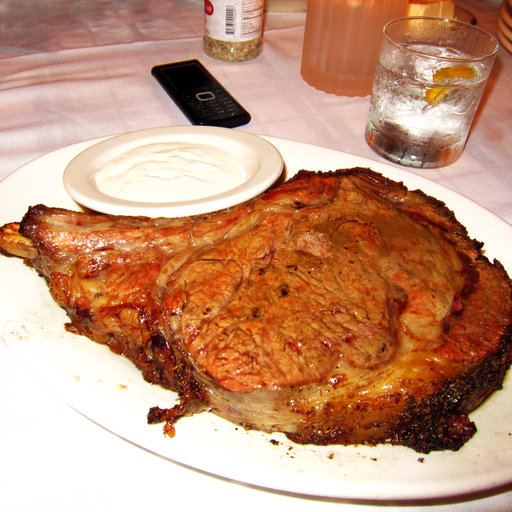

In [7]:
import random 
from PIL import Image

random.seed(42)

# Get all image paths
impage_paths_list = list(image_path.glob("*/*/*.jpg")) 

# 2. Get a ramdom image path(
random_image_path = random.choice(impage_paths_list)


# 3. Get image class from path name:
##the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
# 4. Open the image and print it
img = Image.open(random_image_path)

# 5. Print 
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")

img

We can do the same thing with `matplotlib.pyplot.imshow()` expect we would have to convert the image to NumPy first

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

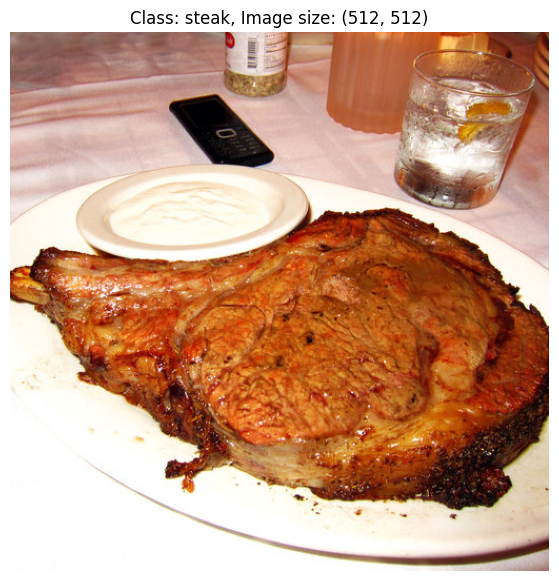

In [8]:
import numpy as np
import matplotlib.pyplot as plt


img_as_numpy = np.array(img)
plt.figure(figsize=(10, 7))
plt.imshow(img_as_numpy)
plt.title(f"Class: {image_class}, Image size: {img.size}")
plt.axis(False)


## 3. Transforming data

In order to load images in PyTorch, we need to do the following few things:

    1. Turn it into tensors(numerical representations of our images)
    2. Turn into `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`

There are several different kinds of pre-built datasets and dataset loaders for PyTorch, depending on the problem you're working on. 

| **Problem space** | **Pre-built Datasets and Functions** |
| ----- | ----- |
| **Vision** | [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) |
| **Audio** | [`torchaudio.datasets`](https://pytorch.org/audio/stable/datasets.html) |
| **Text** | [`torchtext.datasets`](https://pytorch.org/text/stable/datasets.html) |
| **Recommendation system** | [`torchrec.datasets`](https://pytorch.org/torchrec/torchrec.datasets.html) |

Since we're working with a vision problem, we'll be looking at `torchvision.datasets` for our data loading functions as well as [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) for preparing our data.

Let's import some base libraries.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms



### 3.1 Transforming data with torchvision.transforms


Currently what we have is the data sets are png which we converted to numpy in previou section. However, what we need now is to convert these numpy arrays into tensors such that PyTorch can work with. 

One of the ways we can do this is by using the `torchvisino.transforms` module.

`torchvisino.transforms` contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation(practice of altering data and make it harder for model to learn). [数据增强]


Let's code out the following transform steps:

1. Resize the images using `transforms.Resize()` (from 512x512 to 64x64, the same shape as the images on CNN Explainer Website.)

2. Flip our images randomly on the horizontal using `transforms.RandomHorizontalFlip()` (as a form of data augmentation)

3. Turn our images from PIL images to a PyTorch tensor using transforms.ToTensor().

We can compile all these steps using torchvision.transforms.Compose(). 

